## Summary
---

### Setup
- **OS**: Linux is superior in convenience and stability. 
    - A WSL (Windows-Subsystem Linux) is a convienient solution for Windows.
- **Virtual environment**: both, conda or venv, work fine. Conda is used here.
- **Versions**
    - Python 3.9.* is recommended here: https://www.tensorflow.org/install/pip

## Prerequisites
---

### Development environment
---

We use Tensorflow Federated (TFF). For further development e.g. is considerded 

#### OS - Linux is recommended

##### Windows restrictions

Tensorflow (TF) and Tensorflow Federated (TFF) have only restricted Windows support, e.g.

- **TFF - several problems**, e.g.
  - installing TFF does run infinitely because of not resolvable dependencies, see https://stackoverflow.com/questions/69949143/tensorflow-federated-on-windows
  - needed JAX has no Windows support, see https://github.com/google/jax/issues/438. JAX Team:
    
    >*Windows support is still not on the agenda. We're maxed out on other things, and moreover no one on the JAX team is a Windows user, which only makes development harder.*
  - XLA (JAX dependency) was not fully compilable, but should now be available since TF 2.2.0.
- **TF - no GPU support**, s. https://www.tensorflow.org/install/pip#windows-native
  
  > *Starting with TensorFlow 2.11, you will need to install TensorFlow in WSL2, or install tensorflow or tensorflow-cpu and, optionally, try the TensorFlow-DirectML-Plugin.*

##### Windows-Subsystem for Linux

**A Windows-Subsystem for Linux (WSL) can be a convenient solution**, see

- Install Tensorflow using a WSL: https://www.tensorflow.org/install/pip#windows-wsl2
- tutorial for setting up GPU support: https://www.youtube.com/watch?v=0S81koZpwPA&t=518s&pp=ygUOd3NsIHRlbnNvcmZsb3c%3D
- General development environment in VSCode using WSL: https://code.visualstudio.com/docs/remote/wsl

##### MacOS restrictions

TFF is not fully available for MacOS, e.g. ...
- only outdated versions are available, see https://github.com/tensorflow/federated/issues/3881
- installation is complicated and partly sketchy, see
  - https://stackoverflow.com/questions/66705900/can-tensorflow-federated-be-installed-on-apple-silicon-m1
  - https://stackoverflow.com/questions/71839866/can-anyone-give-me-a-comprehensive-guide-to-installing-tensorflow-federated-on-m1
  - https://discuss.tensorflow.org/t/update-tensorflow-federated-to-match-tensorflow-macos-2-7-0-and-tensorflow-metal-0-3-0/7193/10
  - conda-forge could help: https://stackoverflow.com/questions/68327863/importing-jax-fails-on-mac-with-m1-chip

#### Virtual environment


Recommended virtual environments are:

1. environment by ``conda`` using Python 3.9.* for TensorFlow, see [Install TensorFlow with pip](https://www.tensorflow.org/install/pip) (works fine for Tensorflow Federated)
2. environment by ``venv``, see [Install TensorFlow Federated](https://www.tensorflow.org/federated/install)

#### Versions

- Python 3.9.* is recommended here: https://www.tensorflow.org/install/pip
    - rem.: [asdf-vm](https://asdf-vm.com/) is convenient to manage python versions. 
- to reproduce the used environment use (recommended):
    - ``!pip install -r ../requirements.txt``
- to install a new similiar environment use:
    - ``pip install --upgrade tensorflow-federated``  
    - simlilarly install further helpful packages

For the full list of install packages see [requirements.txt](../requirements.txt). E.g. the following tensorflow[...] versions are used.

In [25]:
!pip list | grep tensorflow
# for more details use !pip show tensorflow

/bin/bash: /home/olihauke/.asdf/installs/python/miniconda3-latest/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
tensorflow                    2.12.0
tensorflow-compression        2.12.0
tensorflow-datasets           4.9.2
tensorflow-estimator          2.12.0
tensorflow-federated          0.56.0
tensorflow-io-gcs-filesystem  0.32.0
tensorflow-metadata           1.13.1
tensorflow-model-optimization 0.7.3
tensorflow-privacy            0.8.8
tensorflow-probability        0.15.0


In [26]:
# Save the package versioning to requirements.txt if needed (ovewrites the previous)
#!pip freeze > ../requirements.txt

/bin/bash: /home/olihauke/.asdf/installs/python/miniconda3-latest/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)


### Imports
---

In [72]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from math import floor
import time

import tensorflow as tf
import tensorflow_federated as tff
from keras.models import Sequential
from keras.layers import Dense, InputLayer

# -> check tff
#print(tff.federated_computation(lambda: 'Hello World')()) 

### Ingest data
---

In [32]:
df = pd.read_csv("https://raw.githubusercontent.com/Olhaau/fl-official-statistics-addon/main/output/data/insurance-clean.csv", index_col = 0)
df.head()

,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.92400,0.0,0.0,0.0,1.0
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.55230,0.0,0.0,1.0,0.0
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.46200,0.0,0.0,1.0,0.0
3,0.326087,1.0,0.181464,0.0,0.0,northwest,21984.47061,0.0,1.0,0.0,0.0
4,0.304348,1.0,0.347592,0.0,0.0,northwest,3866.85520,0.0,1.0,0.0,0.0


##### Evaluation splits

In [36]:
nfolds = 5
nreps = 5

cv = RepeatedStratifiedKFold(n_splits = nfolds, n_repeats = nreps, random_state = 42)

ind = 0
for train, test in cv.split(df, df.region):
  
  label = 'rep' + str(floor(ind / nfolds)) + '-fold' + str(ind % nfolds)
  df.loc[train, label] = 'train'
  df.loc[test,  label] = 'test'
  ind += 1

df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'region0', 'region1', 'region2', 'region3', 'rep0-fold0', 'rep0-fold1',
       'rep0-fold2', 'rep0-fold3', 'rep0-fold4', 'rep1-fold0', 'rep1-fold1',
       'rep1-fold2', 'rep1-fold3', 'rep1-fold4', 'rep2-fold0', 'rep2-fold1',
       'rep2-fold2', 'rep2-fold3', 'rep2-fold4', 'rep3-fold0', 'rep3-fold1',
       'rep3-fold2', 'rep3-fold3', 'rep3-fold4', 'rep4-fold0', 'rep4-fold1',
       'rep4-fold2', 'rep4-fold3', 'rep4-fold4'],
      dtype='object')

##### Select feature and target

In [92]:
features = ['age', 'sex', 'bmi', 'children', 'smoker'
            , 'region0', 'region1', 'region2', 'region3']
target = 'charges'

#### Train Test Selector

In [215]:
def select_split(
      df, 
      target = target, 
      features = features, 
      type = 'train', 
      rep = 0, 
      fold = 0
      ):
   """selects the train and test set from a specific column.

  Parameters
  ------------
  df: dataFrame
  target: str
  features: list of str
  type: str
      'train' or 'test'.
  rep, fold: int
      Considered is a repeated cross validation with ``rep`` repetions and ``fold`` folds.
  """
   
   labels = 'rep' + str(rep) + '-fold' + str(fold)
   
   X = df.loc[df[labels] == type, features]
   y = df.loc[df[labels] == type, target]
   
   return X, y

In [214]:
# test
X_train, y_train = get_split(
   features = features + ['rep' + str(1) + '-fold' + str(0)],
   type = 'train', rep = 1, fold = 0
   )
X_test, y_test = get_split(
   features = features + ['rep' + str(0) + '-fold' + str(0)],
   type = 'test', rep = 0, fold = 0
   )
print("====== Train ======")
print(X_train.head())
print("\n====== Test ======")
print(X_test.head())

del X_train, y_train, X_test, y_test

====== Train ======
        age  sex       bmi  children  smoker  region0  region1  region2  \
1  0.000000  1.0  0.479150       0.2     0.0      0.0      0.0      1.0   
2  0.217391  1.0  0.458434       0.6     0.0      0.0      0.0      1.0   
3  0.326087  1.0  0.181464       0.0     0.0      0.0      1.0      0.0   
5  0.282609  0.0  0.263115       0.0     0.0      0.0      0.0      1.0   
6  0.608696  0.0  0.470272       0.2     0.0      0.0      0.0      1.0   

   region3 rep1-fold0  
1      0.0      train  
2      0.0      train  
3      0.0      train  
5      0.0      train  
6      0.0      train  

====== Test ======
         age  sex       bmi  children  smoker  region0  region1  region2  \
8   0.413043  1.0  0.373150       0.4     0.0      1.0      0.0      0.0   
18  0.826087  1.0  0.654829       0.0     0.0      0.0      0.0      0.0   
25  0.891304  0.0  0.316384       0.6     0.0      0.0      0.0      1.0   
27  0.804348  0.0  0.452381       0.4     0.0      0.0      1

### Model wrapper
---

In [180]:
def build_model(
    nfeatures = 9,
    units = [40, 40, 20], 
    activations = ['relu'] * 3, 
    ):
  
  """Construct a fully connected neural network and compile it.
  
  Parameters
  ------------
  nfeatures: int, optional
    Number of input features. Default is 9.
  units: list of int, optional
    List of number of units of the hidden dense layers. The length of ``units`` defines the number of hidden layers. Default are 3 layers with 40, 40 an 20 units, respectively.
  activations: list of str, optional
    List of activation functions used in the hidden layers.

  Return
  ------------
    model: keras.engine.sequential.Sequential
      Keras sequential fully connected neural network.
  """
  
  model = Sequential()
  model.add(InputLayer(input_shape = [nfeatures]))
  for ind in range(len(units)):
    model.add(Dense(
      units = units[ind], 
      activation = activations[ind]
      ))
  model.add(Dense(1))
  
  return model

build_model().summary()

Model: "sequential_150"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_600 (Dense)           (None, 40)                400       
                                                                 
 dense_601 (Dense)           (None, 40)                1640      
                                                                 
 dense_602 (Dense)           (None, 20)                820       
                                                                 
 dense_603 (Dense)           (None, 1)                 21        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


In [55]:
# Visualization
#import keras_visualizer as kv
#model = build_model()
#kv.visualizer(model, file_format = 'png', file_name = '../output/plots/_original_model', view=True)
#Image('output/plots/_original_model.png')

In [233]:
def train_model(
    model,
    X_train,
    y_train,
    loss = 'mean_squared_error',
    optimizer = tf.optimizers.Adam(learning_rate = .05),
    metrics = ["mae", 'mean_squared_error', r2_score], 
    run_eagerly = True,
    batch_size = 128,
    shuffle = True,
    epochs = 100,
    validation_split = 0.2,
    verbose = 0,
    msr = 'loss'
    ):
  
  """Compile and train a Keras neural network.
  
  Parameters
  ------------
  loss: str, optional
    Used loss function for compiling.
  optimizer: keras.optimizers, optional
    Used optimizer for compiling.
  metrics: list of str or sklearn.metrics
    List of metrics for compiling.
  run_eagerly: bool
    Parameter for compilin.g
  batch_size: int
    batch_size of model.fit(...)
  shuffle: bool
  epochs: int
  validation_split: float
  verbose: int
    verbose of model.fit(...)
  msr: str
    measure for custom output
    

  Return
  ------------
    hist: keras.callbacks.History
      History of model.fit(...)
  """

  #model.compile(
  #  loss = loss,
  #  optimizer = optimizer,
  #  metrics = metrics,
  #  run_eagerly = run_eagerly
  #)

  # fit with custom verbose
  starttime = time.time()
  hist = model.fit(
    X_train, 
    y_train,
    batch_size = batch_size, 
    shuffle = shuffle,
    validation_split = validation_split,
    epochs = epochs,
    verbose = verbose
  )
  print(
      "R^2  = %.4f, " % hist.history[msr][-1],
      "time = %.1f sec" % ((time.time() - starttime)))
  
  return hist

In [235]:

model            = build_model()

model.compile(
    loss        = 'mean_squared_error', 
    optimizer   = tf.optimizers.Adam(learning_rate = .05),
    metrics     = ["mae", 'mean_squared_error', r2_score], 
    run_eagerly = True
)

X_train, y_train = select_split(df, type = 'train', rep = 0, fold = 0)
hist             = train_model(model, X_train, y_train, epochs = n_epoch)


R^2  = 92116640.0000,  time = 2.9 sec


## Experiments
---

### Centralized Model
---

#### Training

In [239]:
%%time

n_epochs = 100

hists = []
for rep, fold in product(range(nreps), range(nfolds)):
    print('======= rep %s - fold %s  =======' % (rep, fold))
    
    model           = build_model()

    model.compile(
        loss        = 'mean_squared_error', 
        optimizer   = tf.optimizers.Adam(learning_rate = .05),
        metrics     = ["mae", 'mean_squared_error', r2_score], 
        run_eagerly = True
    )
    tf.random.set_seed(42)

    X_train, y_train = select_split(df, type = 'train', rep = rep, fold = fold)
    hist             = train_model(model, X_train, y_train, epochs = n_epochs, msr = "r2_score")
    hists.append(hist)

======= rep 0 - fold 0  =======
R^2  = 0.8433,  time = 48.0 sec
======= rep 0 - fold 1  =======
R^2  = 0.8518,  time = 45.7 sec
======= rep 0 - fold 2  =======
R^2  = 0.8508,  time = 44.2 sec
======= rep 0 - fold 3  =======
R^2  = 0.8343,  time = 42.9 sec
======= rep 0 - fold 4  =======
R^2  = 0.8437,  time = 45.7 sec
======= rep 1 - fold 0  =======
R^2  = 0.8463,  time = 43.3 sec
======= rep 1 - fold 1  =======
R^2  = 0.8403,  time = 43.0 sec
======= rep 1 - fold 2  =======
R^2  = 0.8621,  time = 40.5 sec
======= rep 1 - fold 3  =======
R^2  = 0.8380,  time = 41.2 sec
======= rep 1 - fold 4  =======
R^2  = 0.8293,  time = 60.3 sec
======= rep 2 - fold 0  =======
R^2  = 0.8412,  time = 51.1 sec
======= rep 2 - fold 1  =======
R^2  = 0.8467,  time = 49.2 sec
======= rep 2 - fold 2  =======
R^2  = 0.8447,  time = 46.5 sec
======= rep 2 - fold 3  =======
R^2  = 0.8470,  time = 45.5 sec
======= rep 2 - fold 4  =======
R^2  = 0.8468,  time = 39.4 sec
======= rep 3 - fold 0  =======
R^2  = 0

#### Evaluation

In [241]:
def test_model(hist, X_test, y_test, verbose = 0):
  rtime = time.time() 
  perf = hist.model.evaluate(X_test, y_test, verbose = 0)[1:]
  rtime = time.time() - rtime
  if verbose != 0: print('time - test: %.2f' % (rtime / 60))
  return perf

def apply_test_model(ind, hist, verbose = 0):
  # label
  rep = int(np.floor(ind / nfolds))
  fold = ind % nfolds
  label = 'rep' + str(rep) + '-fold' + str(fold)
  if verbose != 0: print('====== rep %s - fold %s  ======' % (rep, fold))

  # test data
  X_test = df.loc[df[label] == 'test', features]
  y_test = df[[target]][df[label] == 'test']

  perf = test_model(hist, X_test, y_test, verbose = verbose)
  if verbose != 0: print('Performance: ', perf)
  return perf

In [242]:
# calculate the performance
perfs = []
for ind in range(nreps * nfolds):
  perf = apply_test_model(ind, hist = hists[ind])
  perfs.append(perf)

In [243]:
perfs_df = pd.DataFrame(perfs, columns = ["MAE", 'MSE', 'RSQ']).assign(
    RMSE   = lambda x: np.sqrt(x.MSE),
    RSQ_pct = lambda x: x.RSQ * 100
)
perfs_df[['MAE', 'RMSE', 'RSQ_pct']].sort_values('RSQ_pct').round(2)



,MAE,RMSE,RSQ_pct
7,3443.26,5952.03,72.57
21,3303.12,5732.81,74.36
1,3204.57,5393.12,75.73
16,3062.39,4694.00,76.56
17,3273.45,4962.18,78.16
12,3036.25,5045.35,78.29
4,2899.93,5135.19,78.39
6,2987.20,4917.37,78.43
19,3474.04,5414.71,78.69
23,3044.07,4861.00,78.96


In [244]:
perfs_df[['MAE', 'RMSE', 'RSQ_pct']].describe()[1:].round(2)

,MAE,RMSE,RSQ_pct
mean,2946.99,4894.71,80.83
std,272.45,423.47,3.96
min,2507.12,4196.52,72.57
25%,2762.79,4607.20,78.39
50%,2886.80,4801.24,80.72
75%,3150.52,5135.19,83.79
max,3474.04,5952.03,87.76


In [245]:
def plot_perf(hist, msr = 'loss'):
  """Plot the training history and save the figure.
  :param hist: The history object including the metrics to plot
  :type hist: keras.callbacks.History
  :param msr: The metrics to plot
  :type msr: str, optional
  """
  plt.plot(hist.history[msr])
  plt.plot(hist.history['val_' + msr])
  plt.ylabel(msr)
  plt.xlabel('epoch')
  plt.legend(['train', 'eval'], loc='upper left')

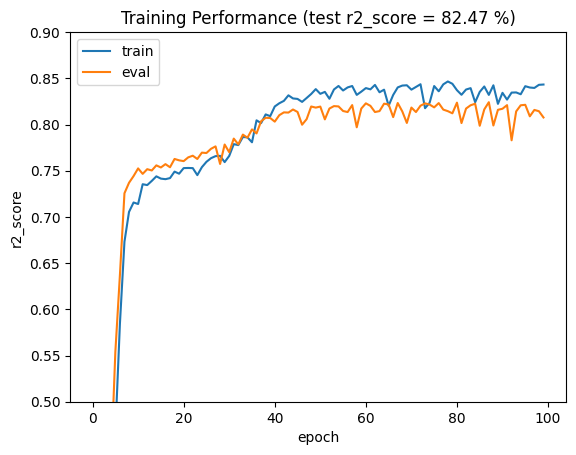

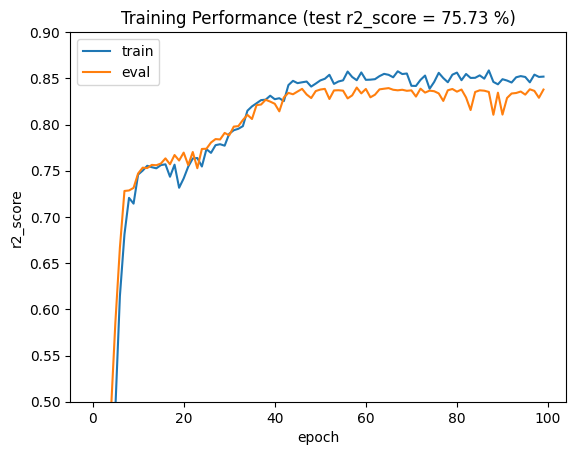

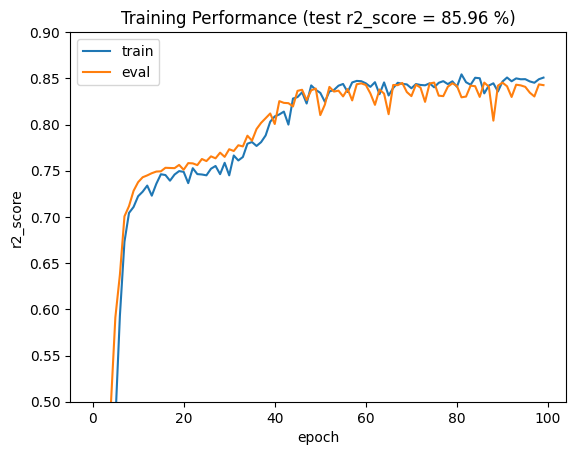

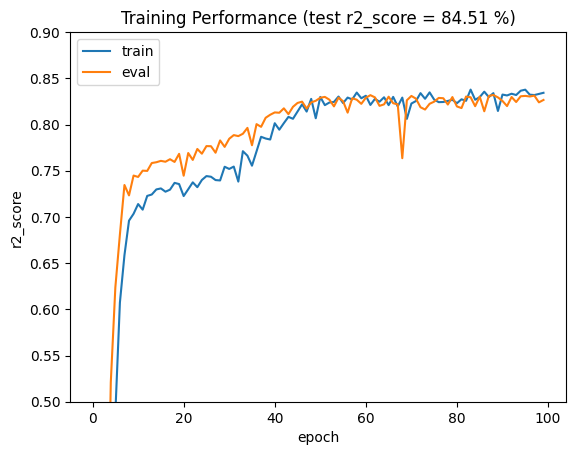

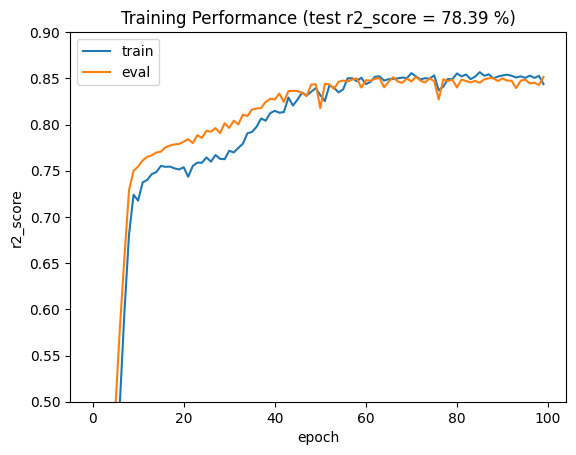

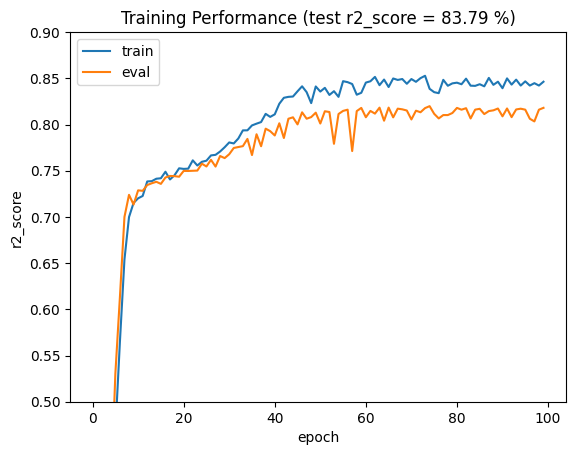

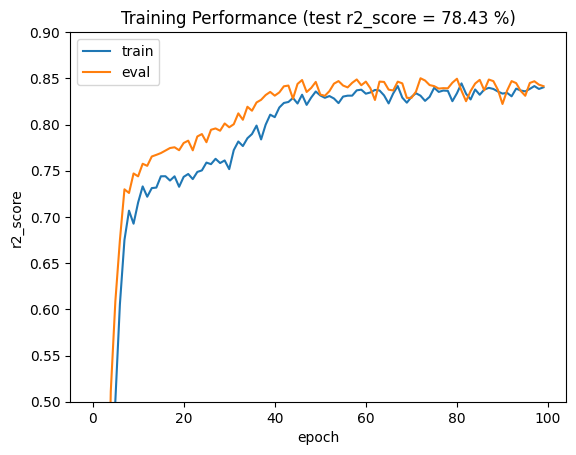

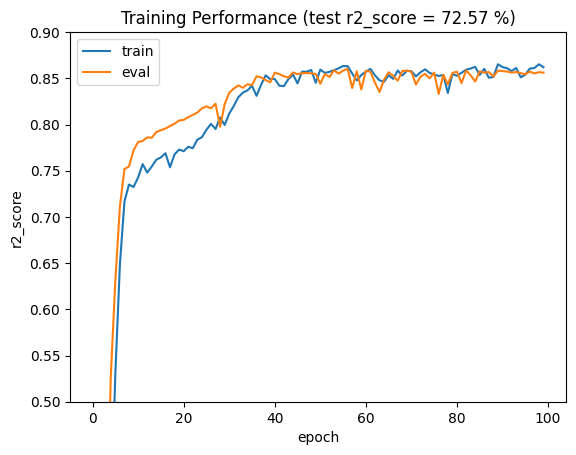

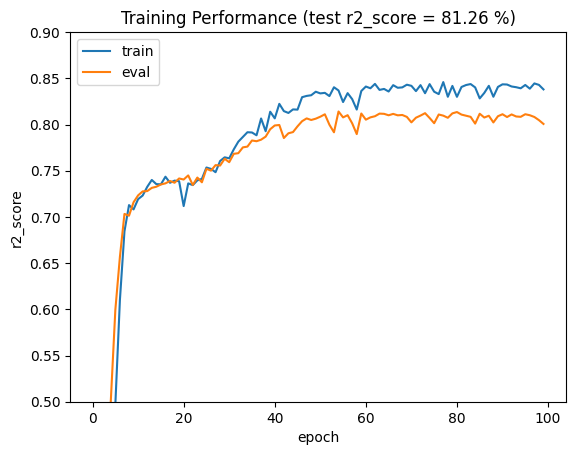

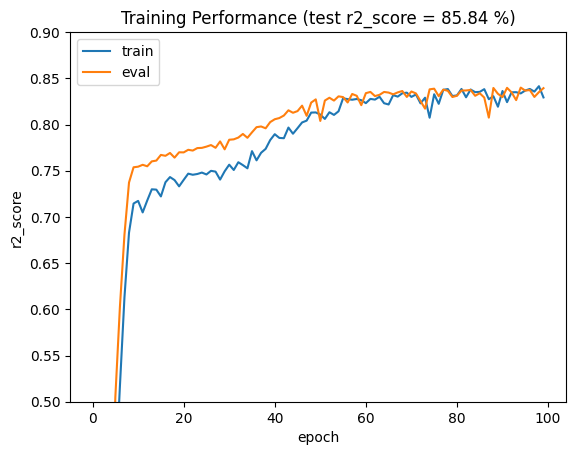

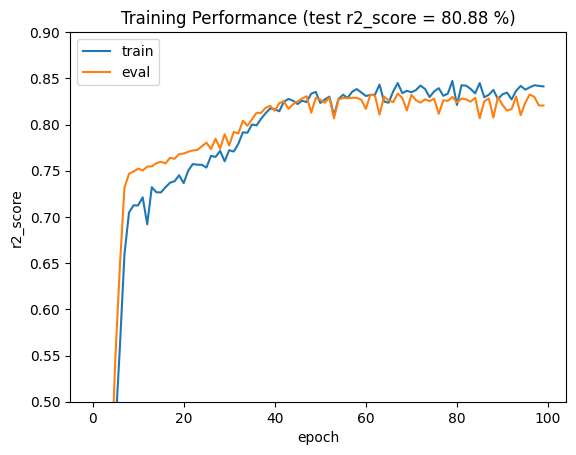

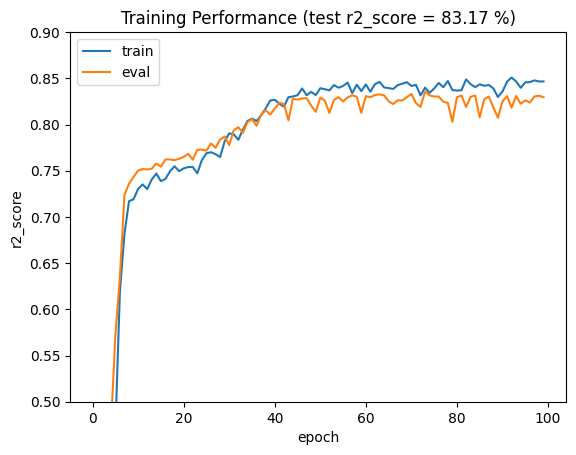

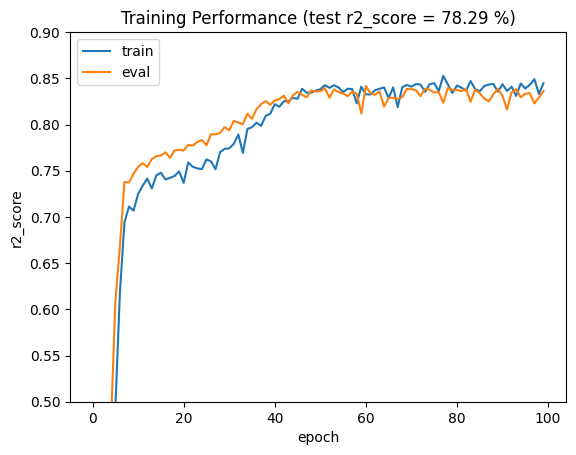

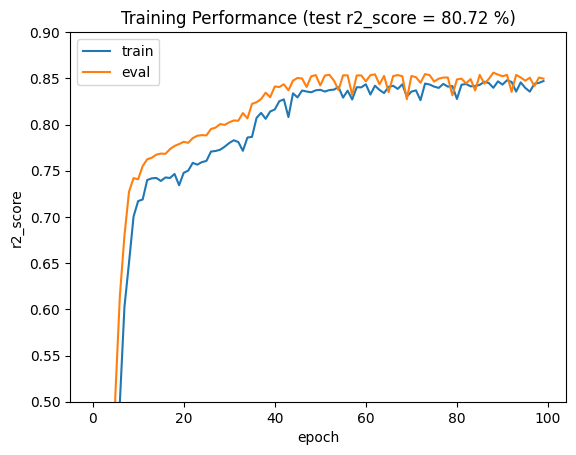

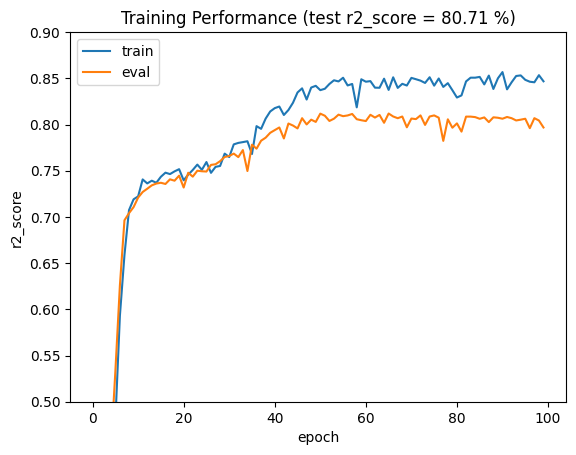

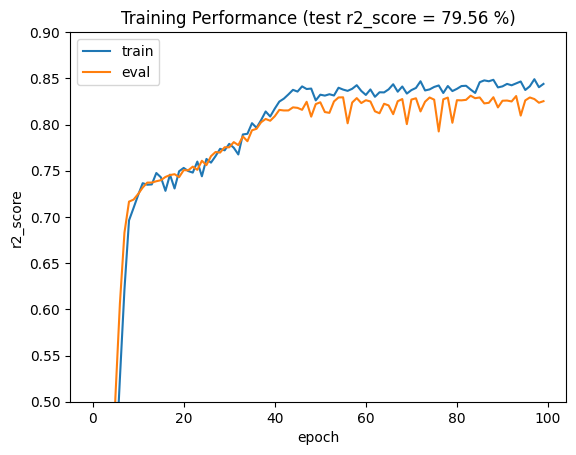

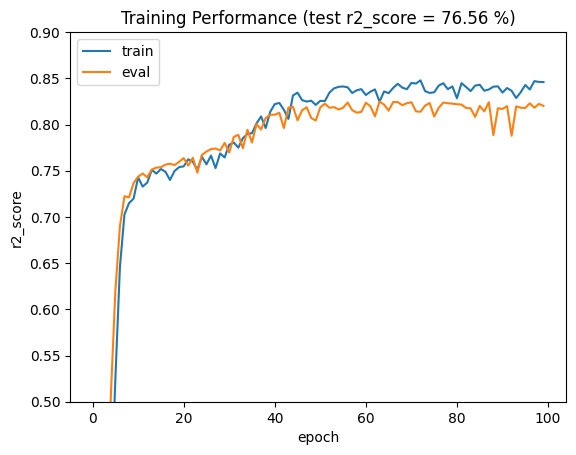

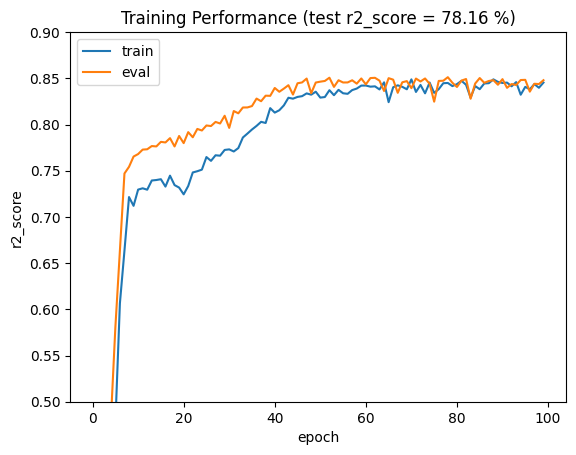

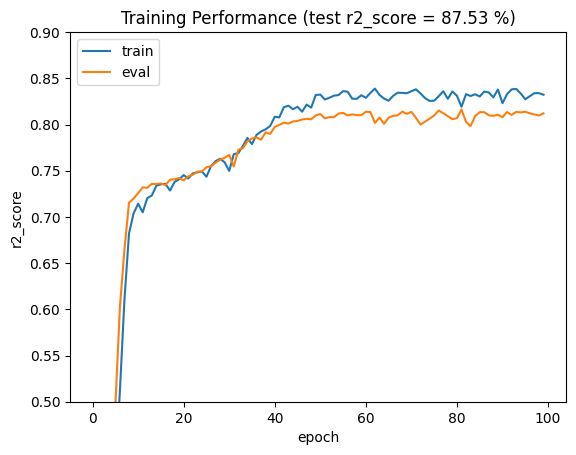

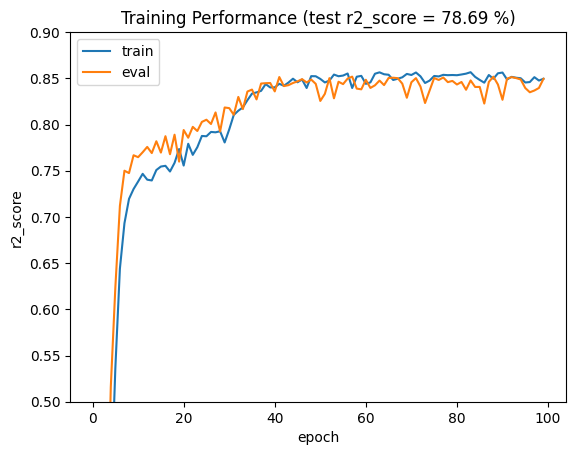

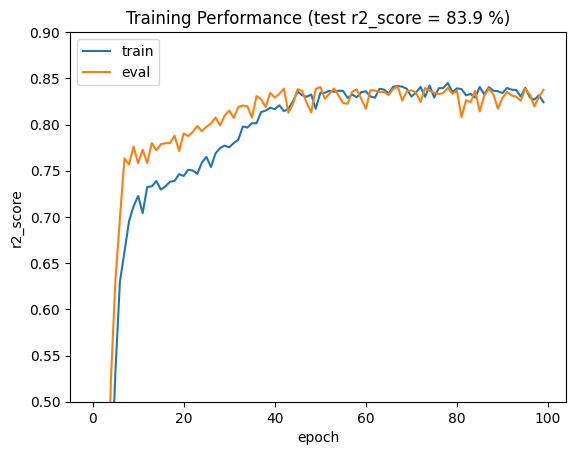

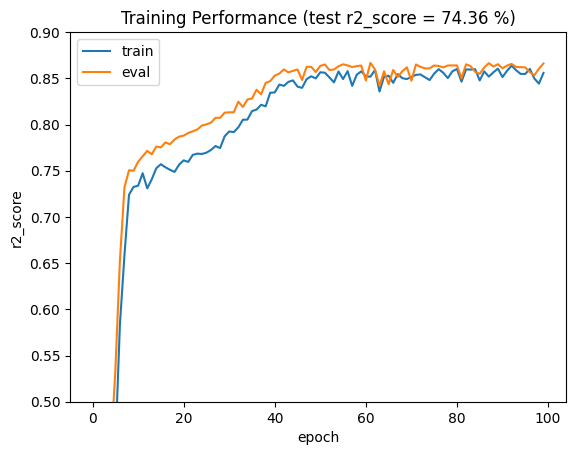

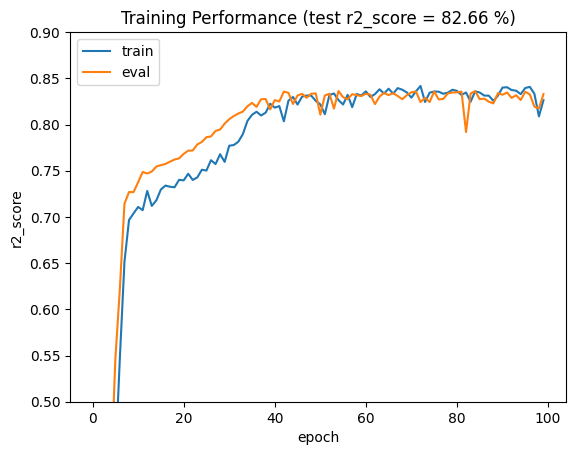

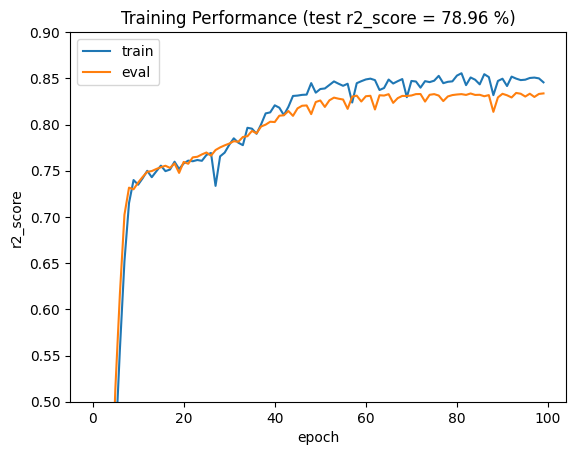

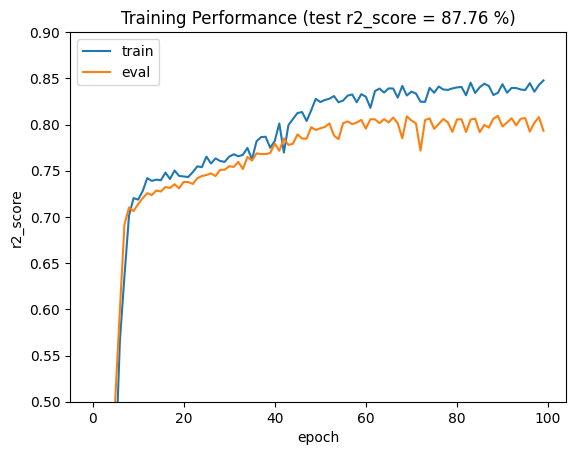

In [246]:
for ind in range(len(hists)):
  plot_perf(hists[ind], 'r2_score')
  plt.title('Training Performance (test r2_score = '+str(round(perfs[ind][2] * 100, 2))+ " %)")
  plt.ylim([0.5, 0.9])
  plt.show()

# Workbench

In [161]:
print("R^2 = %.4f" % hist.history['r2_score'][-1])


R^2 = 0.3134


In [159]:
hist.history['r2_score'][[-1]] * 100

TypeError: list indices must be integers or slices, not list

In [99]:
label = 'rep0-fold0'
X_train = df.loc[df[label] == 'train', features]
y_train = df.loc[df[label] == 'train', target]

In [118]:
hist.history['r2_score'][-1]

0.826330840587616

In [152]:
model = build_model()



hist = model.fit(
      X_train, y_train,
      batch_size = 128, 
      shuffle = True,
      validation_split = 0.2,
      epochs = 5,
      verbose = 2
)

Epoch 1/5


KeyError: in user code:

    File "/home/olihauke/.asdf/installs/python/miniconda3-latest/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 224, in _update_step_xla  *
        return self._update_step(gradient, variable)
    File "/home/olihauke/.asdf/installs/python/miniconda3-latest/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 232, in _update_step  **
        raise KeyError(

    KeyError: 'The optimizer cannot recognize variable dense_116/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.Adam.'


In [97]:
df.loc[      df[label] == 'train', target]

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1332    11411.68500
1333    10600.54830
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1070, dtype: float64

In [98]:
df[[target]][df[label] == 'train']

,charges
0,16884.92400
1,1725.55230
2,4449.46200
3,21984.47061
4,3866.85520
...,...
1332,11411.68500
1333,10600.54830
1335,1629.83350
1336,2007.94500


In [94]:
df[[target]][df[label] == 'train']

,charges
0,16884.92400
1,1725.55230
2,4449.46200
3,21984.47061
4,3866.85520
...,...
1332,11411.68500
1333,10600.54830
1335,1629.83350
1336,2007.94500


In [168]:
for rep, fold in product(range(nreps),range(nfolds)):
    tts_labels = 'rep' + str(rep) + '-fold' + str(fold)

    print(tts_labels)


rep0-fold0
rep0-fold1
rep0-fold2
rep0-fold3
rep0-fold4
rep1-fold0
rep1-fold1
rep1-fold2
rep1-fold3
rep1-fold4
rep2-fold0
rep2-fold1
rep2-fold2
rep2-fold3
rep2-fold4
rep3-fold0
rep3-fold1
rep3-fold2
rep3-fold3
rep3-fold4
rep4-fold0
rep4-fold1
rep4-fold2
rep4-fold3
rep4-fold4


In [60]:
from itertools import product

In [56]:
df

,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,...,rep3-fold0,rep3-fold1,rep3-fold2,rep3-fold3,rep3-fold4,rep4-fold0,rep4-fold1,rep4-fold2,rep4-fold3,rep4-fold4
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.92400,0.0,0.0,0.0,...,train,train,train,train,test,train,train,train,test,train
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.55230,0.0,0.0,1.0,...,train,train,train,train,test,train,train,test,train,train
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.46200,0.0,0.0,1.0,...,train,train,train,test,train,test,train,train,train,train
3,0.326087,1.0,0.181464,0.0,0.0,northwest,21984.47061,0.0,1.0,0.0,...,train,test,train,train,train,train,train,train,test,train
4,0.304348,1.0,0.347592,0.0,0.0,northwest,3866.85520,0.0,1.0,0.0,...,train,train,test,train,train,train,test,train,train,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,0.695652,1.0,0.403820,0.6,0.0,northwest,10600.54830,0.0,1.0,0.0,...,train,train,train,train,test,train,train,test,train,train
1334,0.000000,0.0,0.429379,0.0,0.0,northeast,2205.98080,1.0,0.0,0.0,...,train,train,train,test,train,train,train,test,train,train
1335,0.000000,0.0,0.562012,0.0,0.0,southeast,1629.83350,0.0,0.0,1.0,...,train,train,test,train,train,train,train,train,test,train
1336,0.065217,0.0,0.264730,0.0,0.0,southwest,2007.94500,0.0,0.0,0.0,...,train,test,train,train,train,test,train,train,train,train
